In [1]:
from gwdetectors import *
import Functions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft, fftfreq
from scipy.optimize import fmin
import time
import concurrent.futures

In [2]:
# Define network, detector, signal

c = 299792458.0 # m/s

detector = TwoArmDetector('test', PSDS[KNOWN_PSDS[1]], (0, 0, 0), arms = ((0, 3e-5, 0), (3e-5, 0, 0)), 
                          long_wavelength_approximation=False)

flipped_H = TwoArmDetector('flipped_H', PSDS[KNOWN_PSDS[0]], 
                           np.array([-2.16141492636e+06, -3.83469517889e+06, +4.60035022664e+06])/c,
                           (np.array([-0.22389266154, +0.79983062746, +0.55690487831]) * 4e3/c, 
                            np.array([+0.91397818574, +0.02609403989, -0.40492342125]) * 4e3/c), 
                           long_wavelength_approximation=False)

K_instantiator, K_loc, K_arms = DETECTOR_ORIENTATIONS['K']

kagra = K_instantiator('Kagra', PSDS[KNOWN_PSDS[0]], K_loc, K_arms, long_wavelength_approximation=False)

network = Network(DETECTORS['H_aligo-design'], DETECTORS['L_aligo-design'], 
                  DETECTORS['V_advirgo-design']) # DETECTORS['CE@L_ce-design'], kagra)#, DETECTORS['H_aligo-design']

fsr = 1 / (2 * np.sum(DETECTORS['H_aligo-design'].arms[0]**2)**0.5)

# Pick shape of sine-Gaussian signal pulse
a = 100 # frequency of sinusoidal component 
A = 1e-23 # Gaussian peak amplitude
c = 1 # standard deviation of Gaussian envelope
dt= 0

numpts=120
spread=4

freqs, ast_signal = Functions.produce_freqs_signal(numpts, spread, a, A, c, dt)

info = {'a': a, 'A': A, 'c': c, 'dt':dt, 'network':network}

In [3]:
# Parameters for "true" data

az_true=0
po_true=0
psi_true=0
geocent=0
true_keys=['hp']

true_modes = dict.fromkeys(true_keys, ast_signal)

data = network.project(freqs, geocent, az_true, po_true, psi_true, coord='geographic', **true_modes)

true_snr = network.snr(freqs, geocent, az_true, po_true, psi_true, coord='geographic', **true_modes)

true_params = {'pole': po_true, 'azim':az_true,
               'psi': psi_true, 't0':dt,
               'geocent':geocent, 'modes':true_keys
              }

In [4]:
# Create dictionary with true parameters to store results

current_dict = {'info':info, 'true_params':true_params}

In [25]:
# Calculates optimization over t0, psi, phi0 for a grid of sky locations

npts=30 # resolution for psi, t0 
ranges=((0, np.pi), (dt-0.05, dt+0.05))
ranges_slice = ((0, np.pi, np.pi/45), (dt-0.05, dt+0.05, 0.1/2), (0, 2*np.pi, 2*np.pi/90))
finish_fun=None # note: make finish_fun None, this might be why values of psi are out of bounds
geocent=0
coord='geographic'
keys=['hb']

num=45 # resolution for azims, poles

azimuths = np.linspace(-np.pi, np.pi, num)
poles = np.flip(np.linspace(0, np.pi, num))

Azimuths, Poles = np.meshgrid(azimuths[1:], poles[1:], indexing='ij')
Azimuths_flat = Azimuths.flatten()
Poles_flat = Poles.flatten()
Coords_flat = list(zip(Azimuths_flat, Poles_flat))

optimization_variables = [a, A, c, network, freqs, geocent, data, coord, keys]

if __name__ == '__main__':
    filter_grid = Functions.main(None, num, Coords_flat, 
                                 Functions.filter_3, ranges_slice, npts, finish_fun, optimization_variables)

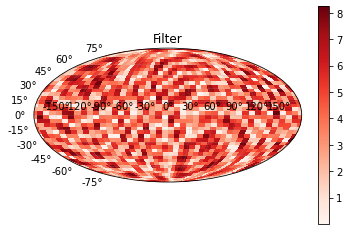

In [26]:
# Plot filter over sky locations

phi_plt = np.linspace(-np.pi, np.pi, num-1)
theta_plt = np.linspace(-np.pi/2., np.pi/2.,num-1)
Phi, Theta = np.meshgrid(phi_plt, theta_plt, indexing='ij')

fig = plt.figure()
ax = fig.add_subplot(111, projection='mollweide')
im = ax.pcolormesh(Phi,Theta, filter_grid, cmap=plt.cm.Reds) 
plt.colorbar(im)
plt.title('Filter')
ax.grid(alpha=0.3, linewidth=0.5)
plt.show()

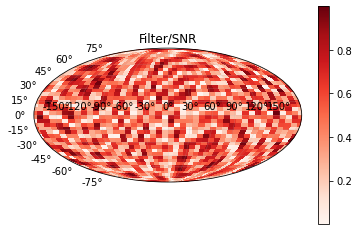

In [27]:
# Plot filter/true snr over sky

phi_plt = np.linspace(-np.pi, np.pi, num-1)
theta_plt = np.linspace(-np.pi/2., np.pi/2.,num-1)
Phi, Theta = np.meshgrid(phi_plt, theta_plt, indexing='ij')

fig = plt.figure()
ax = fig.add_subplot(111, projection='mollweide')
im = ax.pcolormesh(Phi,Theta, filter_grid/true_snr, cmap=plt.cm.Reds) 
plt.colorbar(im)
plt.title('Filter/SNR')
ax.grid(alpha=0.3, linewidth=0.5)
plt.show()

In [28]:
# Overall match

max_filter = np.max(filter_grid)
rho_match = max_filter / true_snr

print(max_filter)
print(rho_match)

8.240409673600247
0.9998513942605259


In [29]:
# Find parameters that give maximum filter response

max_skyindex = np.where(filter_grid == np.max(filter_grid))
max_skyindex_coords = list(zip(max_skyindex[0], max_skyindex[1])) # repacking into coordinate indexes
max_sky_coords = [(azimuths[1:][azim_index], poles[1:][pole_index]) 
                  for (azim_index, pole_index) in max_skyindex_coords]
max_az, max_po = max_sky_coords[0]

print(max_az, max_po)

max_vars = Functions.brute_max(Functions.filter_3, ranges_slice, npts, finish_fun, *optimization_variables, 
                               max_az, max_po)[0]

print(*max_vars)

-2.99879298751753 0.0
0.0 0.0 0.13962634015954636


In [30]:
# store results for individual runs

max_psi, max_t0, max_phi0 = max_vars

# save parameters
run_results = {'match': rho_match, 
               'pole': max_po, 'azim':max_az,
               'psi': max_psi, 't0':max_t0,
               'phi':max_phi0
              }

current_dict[keys[0]] = run_results

In [31]:
# save filter grid array
np.savetxt(f"results/{list(true_kwargs.keys())[0]}_{keys[0]}.txt", filter_grid)

# Final results

In [32]:
# Convert results dictionary into dataframe

df = pd.DataFrame.from_dict(current_dict)
df

,info,true_params,hp,hvx,hb
a,100,NaN,NaN,NaN,NaN
A,0.0,NaN,NaN,NaN,NaN
c,1,NaN,NaN,NaN,NaN
dt,0,NaN,NaN,NaN,NaN
network,"(TwoArmDetector(\n H_aligo-design,\n locatio...",NaN,NaN,NaN,NaN
pole,NaN,0,0.000000,0.000000,0.000000
azim,NaN,0,-1.570796,-0.428399,-2.998793
psi,NaN,0,0.000000,1.396263,0.000000
t0,NaN,0,0.000000,0.000000,0.000000
geocent,NaN,0,NaN,NaN,NaN


In [33]:
# Store final results for a set of true parameters

df.to_csv(f'results/{list(true_kwargs.keys())[0]}_true.csv', index=False)

In [ ]:
df_read = pd.read_csv(f'results/group_2/{list(true_kwargs.keys())[0]}_true.csv', header=False)
df_read